In [1]:
import numpy as np
import torch
from torch.utils.dlpack import to_dlpack
import cupy as cu
from cupyx import scipy
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
device = 'cuda:2' if torch.cuda.is_available() else 'cpu'
device

'cuda:2'

In [4]:
W = 10
H = 10
N = W * H
arr = torch.zeros(H, W, device=device) * 10
arr[2:5, 2:5] = 1
arr

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:2')

In [5]:
# plt.imshow(arr.cpu().numpy())

In [6]:
cust_filter = torch.tensor([[[0, 1, 0], [0, -1, 0], [0, 0, 0]], 
                            [[0, 0, 0], [0, -1, 1], [0, 0, 0]],
                            [[0, 0, 0], [0, -1, 0], [0, 1, 0]],
                            [[0, 0, 0], [1, -1, 0], [0, 0, 0]]], device=device, dtype=torch.float)

In [7]:
cust_filter, cust_filter.shape

(tensor([[[ 0.,  1.,  0.],
          [ 0., -1.,  0.],
          [ 0.,  0.,  0.]],
 
         [[ 0.,  0.,  0.],
          [ 0., -1.,  1.],
          [ 0.,  0.,  0.]],
 
         [[ 0.,  0.,  0.],
          [ 0., -1.,  0.],
          [ 0.,  1.,  0.]],
 
         [[ 0.,  0.,  0.],
          [ 1., -1.,  0.],
          [ 0.,  0.,  0.]]], device='cuda:2'),
 torch.Size([4, 3, 3]))

In [8]:
vectors = torch.nn.functional.conv2d(input=arr[None, None, ...], weight=cust_filter[:, None], padding=1)
vectors = vectors[0]
vectors[0, 0, :] = 0
vectors[1, :, -1] = 0
vectors[2, -1, :] = 0
vectors[3, :, 0] = 0
vectors, vectors.shape

(tensor([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0., -1., -1., -1.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],
 
         [[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  1.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  1.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  1.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
     

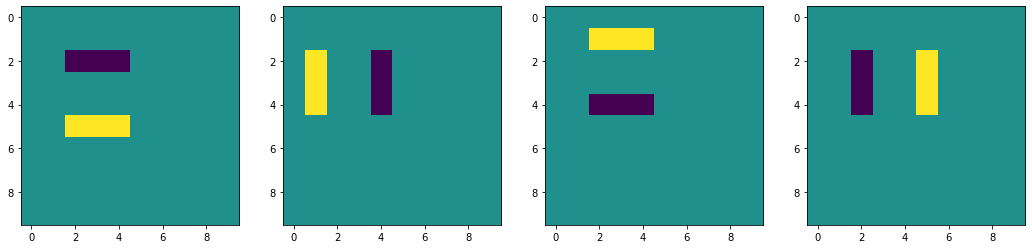

In [9]:
plt.rcParams['figure.figsize'] = [18, 12]
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(vectors[i].cpu().numpy())

In [10]:
square = torch.ones_like(vectors)
square[:-1] += vectors[:-1] ** 2 + vectors[1:] ** 2
square[-1] +=  vectors[0] ** 2 + vectors[-1] ** 2
square = torch.sqrt(square) / 2

In [11]:
square, square.shape

(tensor([[[0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
           0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
           0.5000, 0.5000],
          [0.5000, 0.7071, 0.7071, 0.7071, 0.8660, 0.5000, 0.5000, 0.5000,
           0.5000, 0.5000],
          [0.5000, 0.7071, 0.5000, 0.5000, 0.7071, 0.5000, 0.5000, 0.5000,
           0.5000, 0.5000],
          [0.5000, 0.7071, 0.5000, 0.5000, 0.7071, 0.5000, 0.5000, 0.5000,
           0.5000, 0.5000],
          [0.5000, 0.5000, 0.7071, 0.7071, 0.7071, 0.5000, 0.5000, 0.5000,
           0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
           0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
           0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
           0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000

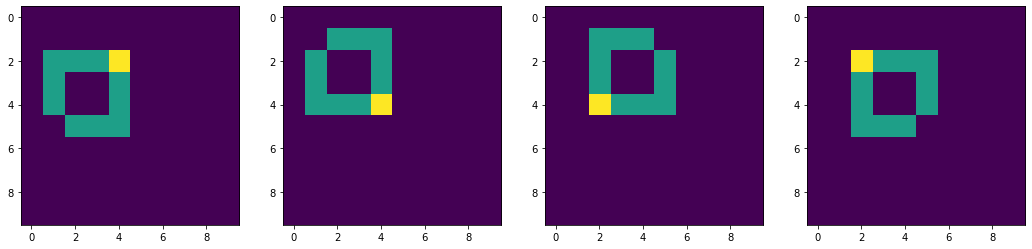

In [12]:
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(square[i].cpu().numpy())

In [13]:
square[0, 0, :] = 0
square[1, :, -1] = 0
square[2, -1, :] = 0
square[3, :, 0] = 0

In [14]:
vertex_area = square.sum(axis=0)

In [15]:
vertex_area, vertex_area.shape

(tensor([[1.0000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
          1.0000],
         [1.5000, 2.0000, 2.4142, 2.4142, 2.4142, 2.0000, 2.0000, 2.0000, 2.0000,
          1.5000],
         [1.5000, 2.4142, 2.7802, 2.4142, 2.7802, 2.4142, 2.0000, 2.0000, 2.0000,
          1.5000],
         [1.5000, 2.4142, 2.4142, 2.0000, 2.4142, 2.4142, 2.0000, 2.0000, 2.0000,
          1.5000],
         [1.5000, 2.4142, 2.7802, 2.4142, 2.7802, 2.4142, 2.0000, 2.0000, 2.0000,
          1.5000],
         [1.5000, 2.0000, 2.4142, 2.4142, 2.4142, 2.0000, 2.0000, 2.0000, 2.0000,
          1.5000],
         [1.5000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
          1.5000],
         [1.5000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
          1.5000],
         [1.5000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
          1.5000],
         [1.0000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         

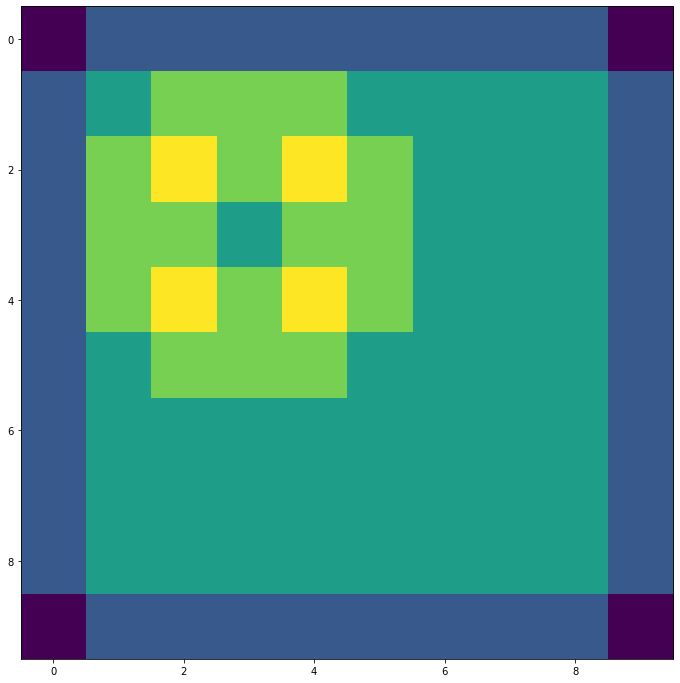

In [16]:
plt.imshow(vertex_area.cpu().numpy())

In [17]:
del square, arr
torch.cuda.empty_cache()

In [28]:
cotangens = torch.zeros_like(vectors)
cotangens[0] = 1 / torch.tan(torch.acos((1 + vectors[3] ** 2 - vectors[3] * vectors[0]) / (torch.sqrt(2 + (vectors[0] - vectors[3]) ** 2) * torch.sqrt(1 + vectors[3] ** 2))))
cotangens[0] += 1 / torch.tan(torch.acos((1 + vectors[1] ** 2 - vectors[1] * vectors[0]) / (torch.sqrt(2 + (vectors[0] - vectors[1]) ** 2) * torch.sqrt(1 + vectors[1] ** 2))))

cotangens[1] = 1 / torch.tan(torch.acos((1 + vectors[0] ** 2 - vectors[0] * vectors[1]) / (torch.sqrt(2 + (vectors[1] - vectors[0]) ** 2) * torch.sqrt(1 + vectors[0] ** 2))))
cotangens[1] += 1 / torch.tan(torch.acos((1 + vectors[2] ** 2 - vectors[2] * vectors[1]) / (torch.sqrt(2 + (vectors[1] - vectors[2]) ** 2) * torch.sqrt(1 + vectors[2] ** 2))))

cotangens[2] = 1 / torch.tan(torch.acos((1 + vectors[3] ** 2 - vectors[3] * vectors[2]) / (torch.sqrt(2 + (vectors[2] - vectors[3]) ** 2) * torch.sqrt(1 + vectors[3] ** 2))))
cotangens[2] += 1 / torch.tan(torch.acos((1 + vectors[1] ** 2 - vectors[1] * vectors[2]) / (torch.sqrt(2 + (vectors[2] - vectors[1]) ** 2) * torch.sqrt(1 + vectors[1] ** 2))))

cotangens[3] = 1 / torch.tan(torch.acos((1 + vectors[0] ** 2 - vectors[0] * vectors[3]) / (torch.sqrt(2 + (vectors[3] - vectors[0]) ** 2) * torch.sqrt(1 + vectors[0] ** 2))))
cotangens[3] += 1 / torch.tan(torch.acos((1 + vectors[2] ** 2 - vectors[2] * vectors[3]) / (torch.sqrt(2 + (vectors[3] - vectors[2]) ** 2) * torch.sqrt(1 + vectors[2] ** 2))))

cotangens[0, 0, :] = 0
cotangens[1, :, -1] = 0
cotangens[2, -1, :] = 0
cotangens[3, :, 0] = 0

In [29]:
main_i = torch.arange(end=N, device=device)
upper_edge_i = torch.arange(start=W, end=N)
right_edge_i = main_i[cotangens[1].view(-1) != 0]
left_edge_i = main_i[cotangens[3].view(-1) != 0]
down_edge_i = torch.arange(start=0, end=N-W)

In [30]:
main_v = cotangens.sum(axis=0).view(-1)
upper_edge_v = cotangens[0].view(-1)[upper_edge_i]
right_edge_v = cotangens[1].view(-1)[right_edge_i]
down_edge_v = cotangens[2].view(-1)[down_edge_i]
left_edge_v = cotangens[3].view(-1)[left_edge_i]

In [31]:
cu.cuda.Device(2).use()

main_v = cu.fromDlpack(to_dlpack(main_v))
main_i = cu.fromDlpack(to_dlpack(main_i))

upper_edge_v = cu.fromDlpack(to_dlpack(upper_edge_v))
upper_edge_i = cu.fromDlpack(to_dlpack(upper_edge_i))

right_edge_v = cu.fromDlpack(to_dlpack(right_edge_v))
right_edge_i = cu.fromDlpack(to_dlpack(right_edge_i))

down_edge_v = cu.fromDlpack(to_dlpack(down_edge_v))
down_edge_i = cu.fromDlpack(to_dlpack(down_edge_i))


left_edge_v = cu.fromDlpack(to_dlpack(left_edge_v))
left_edge_i = cu.fromDlpack(to_dlpack(left_edge_i))

In [32]:
scipy.sparse.dia() ((main_v, (main_i, main_i)), (N, N))